In [ ]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (224, 224)

# Training U-net using HAM10000 dataset

plotting performance

In [ ]:
# plotting performance of models
def plot_performance(hist, metric):

  EPOCHS = len(hist.history['loss'])

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(range(EPOCHS), hist.history['loss'], label='Training')
  plt.plot(range(EPOCHS), hist.history['val_loss'], label='Validation')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(EPOCHS), hist.history[metric], label='Training')
  plt.plot(range(EPOCHS), hist.history['val_' + metric], label='Validation')
  plt.title('Training and Validation ' + metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.legend()

  print(f'Best Training {metric}:', np.around(np.amax(hist.history[metric]), 4))
  print(f'Best Validation {metric}:', np.around(np.amax(hist.history['val_' + metric]), 4))

In [ ]:
images = np.load('/content/drive/MyDrive/HAM10000/new_images.npy')
masks = np.load('/content/drive/MyDrive/HAM10000/new_masks.npy')

In [ ]:
##### Make train/dev/test set

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.1)

print('Train images: ', train_images.shape)
print('Train masks: ', train_masks.shape)
print('Val images: ', val_images.shape)
print('Val masks: ', val_masks.shape)

Train images:  (8649, 128, 128, 3)
Train masks:  (8649, 128, 128, 1)
Val images:  (961, 128, 128, 3)
Val masks:  (961, 128, 128, 1)


In [ ]:
# my coded one
class U_Net(tf.keras.Model):

    def __init__(self):
        super(U_Net, self).__init__()
        
        # Building the U-net model
        self.conv_1a = Conv2D(input_shape=(128,128,3), filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_1b = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')

        self.downstep_a = self.downstep(filters=64)
        self.downstep_b = self.downstep(filters=128)
        self.downstep_c = self.downstep(filters=256)
        self.downstep_d = self.downstep(filters=512)

        self.upsample = UpSampling2D(size=(2, 2))

        self.upstep_a = self.upstep(filters=64)
        self.upstep_b = self.upstep(filters=128)
        self.upstep_c = self.upstep(filters=256)

        self.conv_10a = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_10b = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_10c = Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')
        self.conv_10d = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='sigmoid')


    def downstep(self, filters):
      maxpool = MaxPool2D(pool_size=(2, 2), strides=(2,2))
      conv_1 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
      conv_2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
      step = Sequential()
      step.add(maxpool)
      step.add(conv_1)
      step.add(conv_2)
      return step


    def upstep(self, filters):
      conv_1 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
      conv_2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
      upsample = UpSampling2D(size=(2, 2))
      step = Sequential()
      step.add(conv_1)
      step.add(conv_2)
      step.add(upsample)
      return step


    def call(self, inputs):
        
        # Stepping down the U-net
        layer_1 = self.conv_1a(inputs)
        layer_1 = self.conv_1b(layer_1)
        layer_2 = self.downstep_a(layer_1)
        layer_3 = self.downstep_b(layer_2)
        layer_4 = self.downstep_c(layer_3)
        layer_5 = self.downstep_d(layer_4)
        
        # Stepping up the U-net
        layer_6 = self.upsample(layer_5)
        layer_7 = concatenate([layer_6, layer_4])
        layer_7 = self.upstep_a(layer_7)
        layer_8 = concatenate([layer_7, layer_3])
        layer_8 = self.upstep_b(layer_8)
        layer_9 = concatenate([layer_8, layer_2])
        layer_9 = self.upstep_c(layer_9)
        layer_10 = concatenate([layer_9, layer_1])
        layer_10 = self.conv_10a(layer_10)
        layer_10 = self.conv_10b(layer_10)
        layer_10 = self.conv_10c(layer_10)
        output = self.conv_10d(layer_10)
        
        return output
  

model = U_Net()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

BATCH_SIZE = 64
EPOCHS = 20
hist = model.fit(train_images, train_masks, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/20
136/136 [==============================] - 55s 292ms/step - loss: 0.3767 - accuracy: 0.8534 - val_loss: 0.3050 - val_accuracy: 0.9167
Epoch 2/20
136/136 [==============================] - 38s 278ms/step - loss: 0.2778 - accuracy: 0.9372 - val_loss: 0.2747 - val_accuracy: 0.9353
Epoch 3/20
136/136 [==============================] - 38s 278ms/step - loss: 0.2636 - accuracy: 0.9440 - val_loss: 0.2643 - val_accuracy: 0.9431
Epoch 4/20
136/136 [==============================] - 38s 278ms/step - loss: 0.2553 - accuracy: 0.9484 - val_loss: 0.2648 - val_accuracy: 0.9448
Epoch 5/20
136/136 [==============================] - 38s 278ms/step - loss: 0.2502 - accuracy: 0.9508 - val_loss: 0.2478 - val_accuracy: 0.9499
Epoch 6/20
136/136 [==============================] - 38s 278ms/step - loss: 0.1808 - accuracy: 0.9515 - val_loss: 0.1239 - val_accuracy: 0.9494
Epoch 7/20
136/136 [==============================] - 38s 278ms/step - loss: 0.1122 - accuracy: 0.9551 - val_loss: 0.1381 - val_ac

Best Validation accuracy: 0.9603


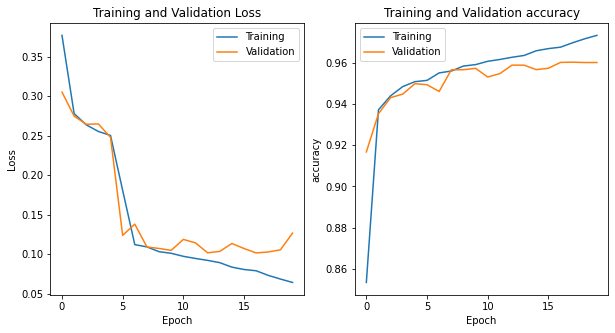

In [ ]:
plot_performance(hist, metric='accuracy')

# Masking ISIC2020 data using trained U-net

In [ ]:
images = np.load('/content/drive/MyDrive/ISIC2020/images.npy')
labels = np.load('/content/drive/MyDrive/ISIC2020/labels.npy')
metadata = np.load('/content/drive/MyDrive/ISIC2020/metas.npy')
masked_images = np.load('/content/drive/MyDrive/ISIC2020/masks.npy')

In [ ]:
unet_model = tf.keras.models.load_model('/content/drive/MyDrive/ISIC2020/unet_model')

new_images = []
shape = (128, 128)
for image in images:
    new_images.append(cv2.resize(image, shape, interpolation=cv2.INTER_CUBIC))
new_images = np.stack(new_images)

masks = unet_model.predict(new_images, verbose=1)

new_masks = []
shape = (224, 224)
for mask in masks:
    new_masks.append(cv2.resize(mask, shape, interpolation=cv2.INTER_LANCZOS4))
masks = np.expand_dims(np.stack(new_masks), -1)
min, max = np.min(masks), np.max(masks)
masks = (masks-min) / (max-min)

masked_images = np.append(images, masks, axis=-1)
np.save('/content/drive/MyDrive/ISIC2020/masks.npy', masked_images)

36/36 [==============================] - 5s 86ms/step


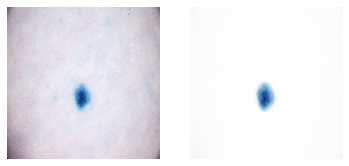

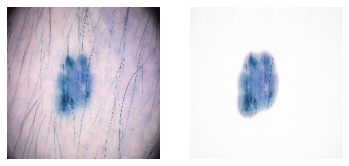

In [ ]:
num_print = 2

for i in range(num_print):
  ran = np.random.randint(0,images.shape[0])
  image = images[ran,:,:,:]
  masked = masked_images[ran,:,:,:]
  plt.figure(frameon=False)
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(image)
  plt.subplot(1,2,2)
  plt.imshow(masked)
  plt.axis('off')

### Train test split

In [ ]:
X = masked_images
X_meta = metadata
y = labels

test_size = 0.11

m = X.shape[0]

shuffle = np.random.permutation(m)
X = X[shuffle]
X_meta = X_meta[shuffle]
y = labels[shuffle]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size/(1-test_size), shuffle=False)
meta_split = np.split(X_meta, [int(m*(1-test_size*2)), int(m*(1-test_size)), m], axis=0)
X_train_meta = meta_split[0]
X_val_meta = meta_split[1]
X_test_meta = meta_split[2]

print('Training examples:', X_train.shape[0])
print('Validation examples:', X_val.shape[0])
print('Test examples:', X_test.shape[0])

Training examples: 893
Validation examples: 126
Test examples: 126


# Building image classification models

# VGG model

In [ ]:
def fc_meta(input1):
  layer1 = Dense(512)(input1)
  layer1 = BatchNormalization()(layer1)
  layer1 = Activation('swish')(layer1)
  layer1 = Dropout(0.3)(layer1)
  layer1 = Dense(128)(layer1)
  layer1 = BatchNormalization()(layer1)
  layer1 = Activation('swish')(layer1)
  layer1 = Flatten()(layer1)
  return layer1

def vgg_block(layer, num_convolutions, num_filters):
  for i in range(num_convolutions):
    conv = Conv2D(filters=num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
    layer = conv(layer)
  maxpool = MaxPool2D(pool_size=(2, 2), strides=(2,2))
  layer = maxpool(layer)
  return layer

def connect(layer0, layer1):
  layer = Concatenate()([layer0, layer1])
  output = Dense(64, activation='relu', kernel_regularizer='l2', kernel_initializer='HeNormal')(layer)
  layer = Dropout(0.5)(layer)
  output = Dense(1, activation='sigmoid')(layer)
  return output

In [ ]:
def vgg_model():

  input0 = Input(shape=(224,224,4))  
  layer0 = vgg_block(input0, 2, 64)
  layer0 = vgg_block(layer0, 2, 128)
  layer0 = vgg_block(layer0, 2, 256)
  layer0 = vgg_block(layer0, 3, 512)
  layer0 = vgg_block(layer0, 3, 512)
  layer0 = Flatten()(layer0)
  layer0 = Dense(4096, activation='swish', kernel_regularizer='l2', kernel_initializer='HeNormal')(layer0)
  layer0 = Dropout(0.5)(layer0)

  input1 = Input(shape=(26))
  layer1 = fc_meta(input1)

  output = connect(layer0, layer1)

  model = Model(inputs=[input0, input1], outputs=output, name='vgg_model')

  return model


model_1 = vgg_model()
model_1.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

BATCH_SIZE = 64
EPOCHS = 150
hist_vgg = model_1.fit([X_train, X_train_meta], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([X_val, X_val_meta], y_val))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
14/14 [==============================] - 9s 441ms/step - loss: 81.6495 - accuracy: 0.4782 - auc: 0.4779 - val_loss: 80.5302 - val_accuracy: 0.4841 - val_auc: 0.5692
Epoch 2/150
14/14 [==============================] - 6s 398ms/step - loss: 79.5901 - accuracy: 0.5196 - auc: 0.5105 - val_loss: 78.4976 - val_accuracy: 0.4921 - val_auc: 0.5928
Epoch 3/150
14/14 [==============================] - 6s 398ms/step - loss: 77.5827 - accuracy: 0.4916 - auc: 0.4934 - val_loss: 76.5131 - val_accuracy: 0.4841 - val_auc: 0.7091
Epoch 4/150
14/14 [==============================] - 6s 398ms/step - loss: 75.6201 - accuracy: 0.4983 - auc: 0.5114 - val_loss: 74.5750 - val_accuracy: 0.6270 - val_auc: 0.7869
Epoch 5/150
14/14 [==============================] - 6s 400ms/step - loss: 73.7029 - accuracy: 0.5431 - auc: 0.5801 - val_loss: 72.6602 - val_accuracy: 0.6746 - val_auc: 0.8045
Epoch 6/150
14/14 [==============================] - 6s 398ms/step - loss: 71.7959 - accuracy: 0.6719 - auc: 0.7242

Best Training auc: 0.9779
Best Validation auc: 0.8866


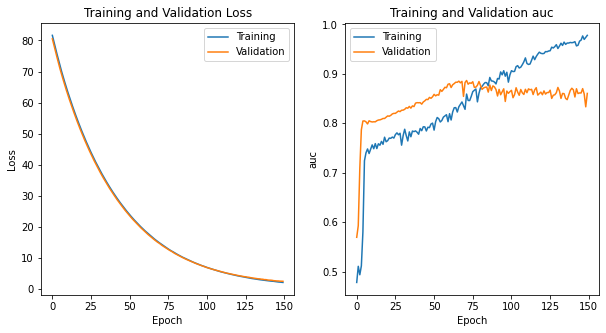

In [ ]:
plot_performance(hist_vgg, 'auc')

In [ ]:
model_1.evaluate([X_test, X_test_meta], y_test, verbose=1)

4/4 [==============================] - 6s 999ms/step - loss: 2.6611 - accuracy: 0.7619 - auc: 0.8292


[2.6611273288726807, 0.761904776096344, 0.8292343616485596]

In [ ]:
model_1.save('/content/drive/MyDrive/ISIC2020/vgg_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ISIC2020/vgg_model/assets


# Siamese approach

In [ ]:
def siamese():

  input0 = Input(shape=(224,224,4))
  input0a = Add()([input0, input0]) / 2 # copying input
  input0b = Add()([input0, input0]) / 2 # copying input

  layer0a = vgg_block(input0a, 2, 64)
  saved = layer0a
  layer0b = vgg_block(input0b, 2, 64)

  layer0 = Concatenate()([layer0a, layer0b])
  layer0 = vgg_block(layer0, 3, 128)

  saved = tf.tile(saved, (1,1,1,2))
  saved = MaxPool2D()(saved)
  layer0 = Add()([layer0, saved])

  layer0a = vgg_block(layer0, 2, 32)
  layer0b = vgg_block(layer0, 2, 32)

  layer0 = Concatenate()([layer0a, layer0b])
  layer0 = Dense(256, kernel_regularizer='l2', kernel_initializer='HeNormal')(layer0)
  layer0 = BatchNormalization(axis=-1)(layer0)
  layer0 = Activation('relu')(layer0)
  layer0 = Dropout(0.5)(layer0)
  layer0 = Flatten()(layer0)

  # metadata
  input1 = Input(shape=(26))
  layer1 = fc_meta(input1)

  output = connect(layer0, layer1)

  model = Model(inputs=[input0, input1], outputs=output, name='Siamese')

  return model

model_2 = siamese()
model_2.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

BATCH_SIZE = 64
EPOCHS = 150
hist_siamese = model_2.fit([X_train, X_train_meta], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([X_val, X_val_meta], y_val))  

Epoch 1/150
14/14 [==============================] - 23s 752ms/step - loss: 5.9108 - accuracy: 0.5510 - auc: 0.5472 - val_loss: 5.7822 - val_accuracy: 0.4444 - val_auc: 0.8010
Epoch 2/150
14/14 [==============================] - 6s 422ms/step - loss: 5.7775 - accuracy: 0.6461 - auc: 0.7114 - val_loss: 5.7737 - val_accuracy: 0.4524 - val_auc: 0.8179
Epoch 3/150
14/14 [==============================] - 6s 421ms/step - loss: 5.7549 - accuracy: 0.6764 - auc: 0.7190 - val_loss: 5.7624 - val_accuracy: 0.4524 - val_auc: 0.8270
Epoch 4/150
14/14 [==============================] - 6s 423ms/step - loss: 5.7666 - accuracy: 0.6450 - auc: 0.6997 - val_loss: 5.7529 - val_accuracy: 0.4762 - val_auc: 0.8223
Epoch 5/150
14/14 [==============================] - 6s 425ms/step - loss: 5.7205 - accuracy: 0.6540 - auc: 0.7147 - val_loss: 5.7450 - val_accuracy: 0.4762 - val_auc: 0.8245
Epoch 6/150
14/14 [==============================] - 6s 424ms/step - loss: 5.6783 - accuracy: 0.6932 - auc: 0.7535 - val_los

Best Training auc: 0.9934
Best Validation auc: 0.8767


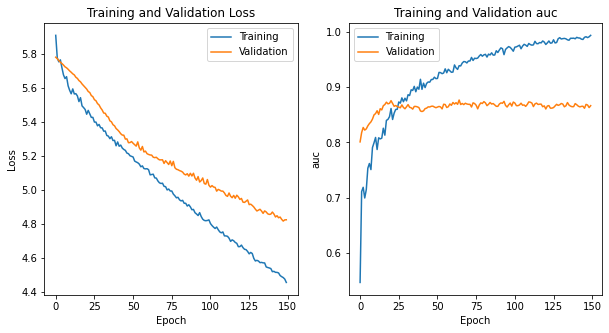

In [ ]:
plot_performance(hist_siamese, metric='auc')

In [ ]:
model_2.evaluate([X_test, X_test_meta], y_test, verbose=2)

4/4 - 3s - loss: 4.8909 - accuracy: 0.7540 - auc: 0.8332 - 3s/epoch - 638ms/step


[4.890927314758301, 0.7539682388305664, 0.833165168762207]

In [ ]:
model_2.save('/content/drive/MyDrive/ISIC2020/siamese_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ISIC2020/siamese_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Transfer learning

In [ ]:
# Using existing models
def transfer(base_model):

  base_model.trainable = True

  input0 = base_model.input
  layer0 = base_model.output
  layer0 = vgg_block(layer0, 1, 64)
  layer0 = Flatten()(layer0)
  layer0 = Dropout(0.5)(layer0)

  input1 = Input(shape=(26))
  layer1 = fc_meta(input1)

  output = connect(layer0, layer1)

  model = Model(inputs=[input0, input1], outputs=output)
  
  return model

X_t = X_train[:,:,:,:-1] * np.expand_dims(X_train[:,:,:,-1], -1)
X_v = X_val[:,:,:,:-1] * np.expand_dims(X_val[:,:,:,-1], -1)
X_te = X_test[:,:,:,:-1] * np.expand_dims(X_test[:,:,:,-1], -1)

efficientnet = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')
model_3 = transfer(efficientnet)
model_3.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

BATCH_SIZE = 64
EPOCHS = 150
hist_transfer = model_3.fit([X_t, X_train_meta], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([X_v, X_val_meta], y_val))

16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
14/14 [==============================] - 20s 617ms/step - loss: 1.4561 - accuracy: 0.5252 - auc: 0.5361 - val_loss: 0.7372 - val_accuracy: 0.4444 - val_auc: 0.4739
Epoch 2/150
14/14 [==============================] - 6s 418ms/step - loss: 1.2833 - accuracy: 0.5532 - auc: 0.5906 - val_loss: 0.7597 - val_accuracy: 0.4444 - val_auc: 0.4934
Epoch 3/150
14/14 [==============================] - 6s 422ms/step - loss: 1.2061 - accuracy: 0.5677 - auc: 0.6074 - val_loss: 0.8424 - val_accuracy: 0.4444 - val_auc: 0.5172
Epoch 4/150
14/14 [==============================] - 6s 423ms/step - loss: 1.1822 - accuracy: 0.5789 - auc: 0.6048 - val_loss: 0.8869 - val_accuracy: 0.4444 - val_auc: 0.5722
Epoch 5/150
14/14 [==============================] - 6s 419ms/step - loss: 1.1103 - accuracy: 0.5991 - auc: 0.6404 - val_loss: 0.9189 - val_accuracy: 0.4444 - val_auc: 0.5191
Epoch 6/150
14/14 [==============================] - 6s 417ms/step - loss: 1.0700 - accuracy: 0.6103 - auc: 0.6600 - val_los

Best Training auc: 0.9935
Best Validation auc: 0.8064


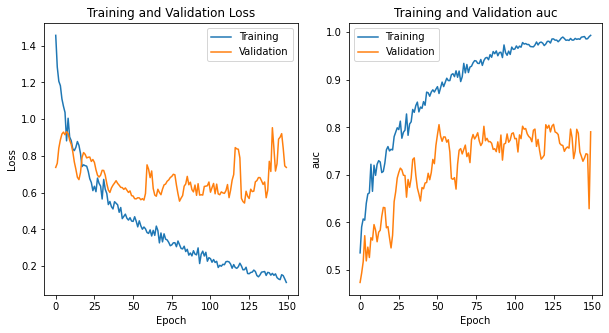

In [ ]:
plot_performance(hist_transfer, 'auc')

In [ ]:
model_3.evaluate([X_te, X_test_meta], y_test)

4/4 [==============================] - 1s 99ms/step - loss: 0.6642 - accuracy: 0.7063 - auc: 0.8101


[0.6642462015151978, 0.7063491940498352, 0.8100882172584534]